In [ ]:
import pandas as pd
import numpy as np
import torch
import time
import sys,os
sys.path.append(os.path.realpath('./src/'))

from utilFuncs import to_np, plotConvergence
from Mesher import RectangularGridMesher
from material import Material
from materialEncoder import MaterialEncoder
from MMTO_2 import TopologyOptimizer
from examples import getBC
import matplotlib.pyplot as plt
plt.show(block=False)
from matplotlib.patches import Ellipse
from smallestEllipse import *

In [2]:
def preprocessData():
  df = pd.read_excel('./data/mat_prop.xlsx')# solidworksMaterialDatabaseCost # aluminum
  dataIdentifier = {'name': df[df.columns[0]], 'className':df[df.columns[1]], 'classID':df[df.columns[2]]} # name of the material and type
  trainInfo = np.log10(df[df.columns[3:]].to_numpy())
  dataScaleMax = torch.tensor(np.max(trainInfo, axis = 0))
  dataScaleMin = torch.tensor(np.min(trainInfo, axis = 0))
  normalizedData = (torch.tensor(trainInfo) - dataScaleMin)/(dataScaleMax - dataScaleMin)
  trainingData = normalizedData.clone().float()

  dataInfo = {'UltimateStrength':{'idx':0,'scaleMin':dataScaleMin[0], 'scaleMax':dataScaleMax[0]},\
              'YieldStress':	{'idx':1,'scaleMin':dataScaleMin[1], 'scaleMax':dataScaleMax[1]},\
              'MassDensity':	{'idx':2,'scaleMin':dataScaleMin[2], 'scaleMax':dataScaleMax[2]},\
              'CostPerPound':{'idx':3,'scaleMin':dataScaleMin[3], 'scaleMax':dataScaleMax[3]},\
              'MeltingTempC':	{'idx':4,'scaleMin':dataScaleMin[4], 'scaleMax':dataScaleMax[4]},\
              'MaxUseTempC':	{'idx':5,'scaleMin':dataScaleMin[5], 'scaleMax':dataScaleMax[5]},\
              'Elong2Fail':{'idx':6,'scaleMin':dataScaleMin[6], 'scaleMax':dataScaleMax[6]},\
              'ElasticModulus':{'idx':7,'scaleMin':dataScaleMin[7], 'scaleMax':dataScaleMax[7]},\
              'CriticalityIdx':{'idx':8,'scaleMin':dataScaleMin[8], 'scaleMax':dataScaleMax[8]}}



  return trainingData, dataInfo, dataIdentifier, trainInfo
trainingData, dataInfo, dataIdentifier, trainInfo = preprocessData()
numMaterialsInTrainingData, numFeatures = trainingData.shape


In [3]:
latentDim, hiddenDim = 2, 250
numEpochs = 40000
klFactor = 5e-5
learningRate = 2e-3
savedNet = './data/vaeNet.nt'
vaeSettings = {'encoder':{'inputDim':numFeatures, 'hiddenDim':hiddenDim,\
                                          'latentDim':latentDim},\
               'decoder':{'latentDim':latentDim, 'hiddenDim':hiddenDim,\
                                          'outputDim':numFeatures}}
materialEncoder = MaterialEncoder(trainingData, dataInfo, dataIdentifier, vaeSettings)
start = time.perf_counter()
materialEncoder.loadAutoencoderFromFile('./data/vaeNet_ref.nt');

# convgHistory = materialEncoder.trainAutoencoder(numEpochs, klFactor, savedNet, learningRate)
print('training time : {:.2F} '.format(time.perf_counter() - start))

training time : 0.00 


In [4]:
plt.close('all')

In [5]:
predData =  materialEncoder.vaeNet(trainingData)



In [6]:
zReal = materialEncoder.vaeNet.encoder.z.detach().numpy()

# print(max(zReal[:,0]), min(zReal[:,0]), max(zReal[:,1]), min(zReal[:,1]))


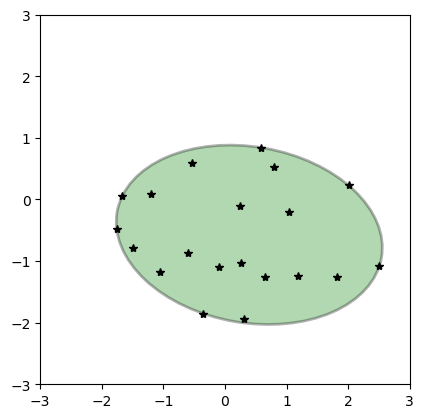

In [7]:
enclosing_ellipse = welzl(np.array(zReal, dtype=float))
# plot resulting ellipse
center,a,b,t = enclosing_ellipse
ellipse = Ellipse(xy=center, width=2*a, height=2*b, angle=np.degrees(t), edgecolor='k', fc='green', alpha=0.3, lw=2)


torch.manual_seed(0)
x = 6* torch.rand(100, 2) - 3
x.requires_grad=True
x_np = to_np(x)
# x = 6 * torch.rand(100, 2) - 3


fig, ax = plt.subplots()
# plt.scatter(x_np[:,0], x_np[:,1], c='r')
ax.plot(zReal[:,0], zReal[:,1], 'k*')
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
ax.add_patch(ellipse)

ax.set_aspect('equal')


plt.show()

constraints = {'distance': {'isOn':False, 'center':center, 'a':a, 'b':b, 'theta':t, 'delta':0.0, 'beta':20}}    



numConstraints 1
massConstraint tensor(1.1796, grad_fn=<SubBackward0>)
massConstraint tensor(0.4402, grad_fn=<SubBackward0>)
Iter 1; J 4.63e+00; vf 0.50
massConstraint tensor(0.4575, grad_fn=<SubBackward0>)


/home/saketh/Research/LS-MMTO/src/utilFuncs.py:335: RuntimeWarning: invalid value encountered in subtract
  dpsidx = plam/ux2-qlam/xl2
/home/saketh/Research/LS-MMTO/src/utilFuncs.py:339: RuntimeWarning: invalid value encountered in subtract
  relam = gvec-a*z-y+s-b


Iter 2; J 4.69e+00; vf 0.31
massConstraint tensor(-0.1107, grad_fn=<SubBackward0>)
Iter 3; J 1.55e+01; vf 0.48
massConstraint tensor(0.3447, grad_fn=<SubBackward0>)
Iter 4; J 3.93e+00; vf 0.51
massConstraint tensor(0.4238, grad_fn=<SubBackward0>)
Iter 5; J 2.60e+00; vf 0.36
massConstraint tensor(-0.0730, grad_fn=<SubBackward0>)
Iter 6; J 6.16e+00; vf 0.39
massConstraint tensor(-0.0244, grad_fn=<SubBackward0>)
Iter 7; J 4.50e+00; vf 0.41
massConstraint tensor(0.0203, grad_fn=<SubBackward0>)
Iter 8; J 3.71e+00; vf 0.40
massConstraint tensor(4.6492e-06, grad_fn=<SubBackward0>)
Iter 9; J 3.65e+00; vf 0.41
massConstraint tensor(0.0076, grad_fn=<SubBackward0>)
Iter 10; J 3.32e+00; vf 0.41


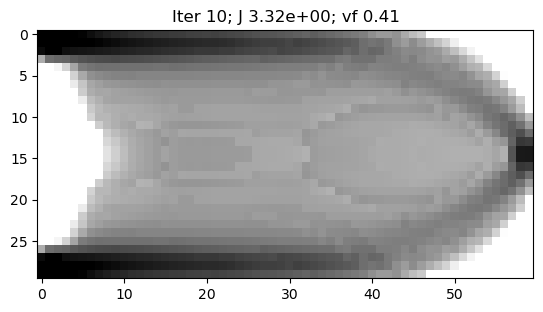

massConstraint tensor(0.0028, grad_fn=<SubBackward0>)
Iter 11; J 3.17e+00; vf 0.41
massConstraint tensor(0.0082, grad_fn=<SubBackward0>)
Iter 12; J 3.01e+00; vf 0.41
massConstraint tensor(6.2704e-05, grad_fn=<SubBackward0>)
Iter 13; J 2.94e+00; vf 0.41
massConstraint tensor(0.0006, grad_fn=<SubBackward0>)
Iter 14; J 2.81e+00; vf 0.41
massConstraint tensor(-0.0021, grad_fn=<SubBackward0>)
Iter 15; J 2.71e+00; vf 0.42
massConstraint tensor(-0.0020, grad_fn=<SubBackward0>)
Iter 16; J 2.58e+00; vf 0.42
massConstraint tensor(-0.0019, grad_fn=<SubBackward0>)
Iter 17; J 2.46e+00; vf 0.42
massConstraint tensor(-0.0023, grad_fn=<SubBackward0>)
Iter 18; J 2.34e+00; vf 0.42
massConstraint tensor(-0.0036, grad_fn=<SubBackward0>)
Iter 19; J 2.21e+00; vf 0.42
massConstraint tensor(-0.0025, grad_fn=<SubBackward0>)
Iter 20; J 2.09e+00; vf 0.42


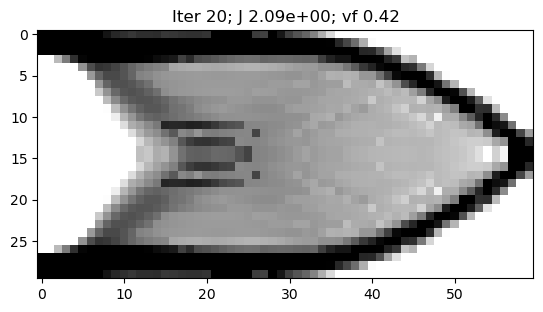

massConstraint tensor(-0.0020, grad_fn=<SubBackward0>)
Iter 21; J 2.01e+00; vf 0.42
massConstraint tensor(-0.0021, grad_fn=<SubBackward0>)
Iter 22; J 1.93e+00; vf 0.42
massConstraint tensor(-0.0024, grad_fn=<SubBackward0>)
Iter 23; J 1.86e+00; vf 0.42
massConstraint tensor(-0.0018, grad_fn=<SubBackward0>)
Iter 24; J 1.79e+00; vf 0.42
massConstraint tensor(-0.0029, grad_fn=<SubBackward0>)
Iter 25; J 1.72e+00; vf 0.42
massConstraint tensor(-0.0027, grad_fn=<SubBackward0>)
Iter 26; J 1.66e+00; vf 0.42
massConstraint tensor(-0.0021, grad_fn=<SubBackward0>)
Iter 27; J 1.60e+00; vf 0.42
massConstraint tensor(-0.0028, grad_fn=<SubBackward0>)
Iter 28; J 1.55e+00; vf 0.42
massConstraint tensor(-0.0027, grad_fn=<SubBackward0>)
Iter 29; J 1.50e+00; vf 0.42
massConstraint tensor(-0.0024, grad_fn=<SubBackward0>)
Iter 30; J 1.45e+00; vf 0.42


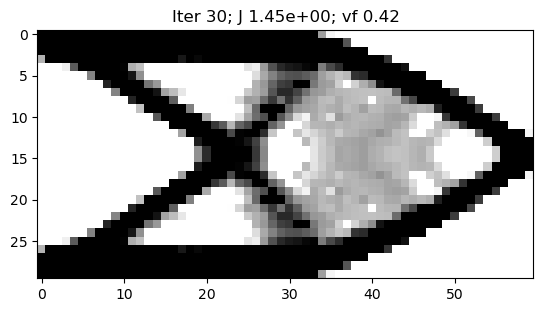

massConstraint tensor(-0.0025, grad_fn=<SubBackward0>)
Iter 31; J 1.42e+00; vf 0.42
massConstraint tensor(-0.0032, grad_fn=<SubBackward0>)
Iter 32; J 1.39e+00; vf 0.42
massConstraint tensor(-0.0026, grad_fn=<SubBackward0>)
Iter 33; J 1.36e+00; vf 0.42
massConstraint tensor(-0.0019, grad_fn=<SubBackward0>)
Iter 34; J 1.34e+00; vf 0.42
massConstraint tensor(-0.0042, grad_fn=<SubBackward0>)
Iter 35; J 1.32e+00; vf 0.42
massConstraint tensor(-0.0013, grad_fn=<SubBackward0>)
Iter 36; J 1.31e+00; vf 0.42
massConstraint tensor(-0.0046, grad_fn=<SubBackward0>)
Iter 37; J 1.30e+00; vf 0.42
massConstraint tensor(-0.0036, grad_fn=<SubBackward0>)
Iter 38; J 1.29e+00; vf 0.42
massConstraint tensor(-0.0056, grad_fn=<SubBackward0>)
Iter 39; J 1.28e+00; vf 0.42
massConstraint tensor(-0.0043, grad_fn=<SubBackward0>)
Iter 40; J 1.26e+00; vf 0.42


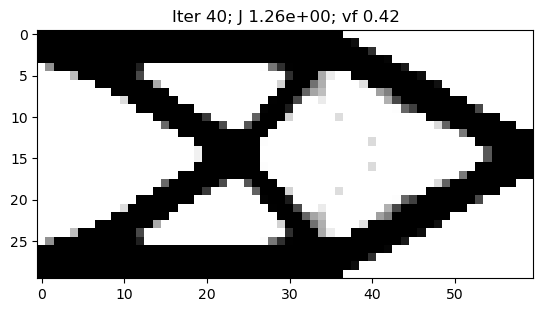

massConstraint tensor(-0.0069, grad_fn=<SubBackward0>)
Iter 41; J 1.25e+00; vf 0.42
massConstraint tensor(-0.0046, grad_fn=<SubBackward0>)
Iter 42; J 1.24e+00; vf 0.42
massConstraint tensor(-0.0022, grad_fn=<SubBackward0>)
Iter 43; J 1.23e+00; vf 0.42
massConstraint tensor(-0.0020, grad_fn=<SubBackward0>)
Iter 44; J 1.23e+00; vf 0.42
massConstraint tensor(-0.0022, grad_fn=<SubBackward0>)
Iter 45; J 1.23e+00; vf 0.42
massConstraint tensor(-0.0042, grad_fn=<SubBackward0>)
Iter 46; J 1.23e+00; vf 0.42
massConstraint tensor(0.0008, grad_fn=<SubBackward0>)
Iter 47; J 1.22e+00; vf 0.42
massConstraint tensor(-0.0018, grad_fn=<SubBackward0>)
Iter 48; J 1.22e+00; vf 0.42
massConstraint tensor(0.0037, grad_fn=<SubBackward0>)
Iter 49; J 1.21e+00; vf 0.42
massConstraint tensor(0.0007, grad_fn=<SubBackward0>)
Iter 50; J 1.22e+00; vf 0.42


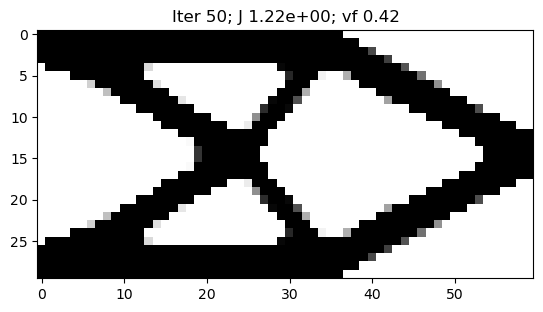

massConstraint tensor(0.0028, grad_fn=<SubBackward0>)
Iter 51; J 1.21e+00; vf 0.42
massConstraint tensor(0.0022, grad_fn=<SubBackward0>)
Iter 52; J 1.21e+00; vf 0.42
massConstraint tensor(-0.0003, grad_fn=<SubBackward0>)
Iter 53; J 1.21e+00; vf 0.42
massConstraint tensor(0.0002, grad_fn=<SubBackward0>)
Iter 54; J 1.21e+00; vf 0.42
massConstraint tensor(0.0049, grad_fn=<SubBackward0>)
Iter 55; J 1.20e+00; vf 0.42
massConstraint tensor(-0.0013, grad_fn=<SubBackward0>)
Iter 56; J 1.21e+00; vf 0.42
massConstraint tensor(0.0003, grad_fn=<SubBackward0>)
Iter 57; J 1.21e+00; vf 0.42
massConstraint tensor(0.0001, grad_fn=<SubBackward0>)
Iter 58; J 1.21e+00; vf 0.42
massConstraint tensor(4.8161e-05, grad_fn=<SubBackward0>)
Iter 59; J 1.21e+00; vf 0.42
massConstraint tensor(0.0002, grad_fn=<SubBackward0>)
Iter 60; J 1.21e+00; vf 0.42


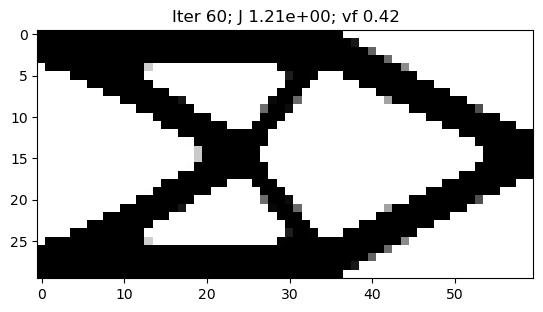

massConstraint tensor(0.0003, grad_fn=<SubBackward0>)
Iter 61; J 1.21e+00; vf 0.42
massConstraint tensor(0.0010, grad_fn=<SubBackward0>)
Iter 62; J 1.20e+00; vf 0.42
massConstraint tensor(-0.0001, grad_fn=<SubBackward0>)
Iter 63; J 1.21e+00; vf 0.42
massConstraint tensor(0.0001, grad_fn=<SubBackward0>)
Iter 64; J 1.21e+00; vf 0.42
massConstraint tensor(0.0002, grad_fn=<SubBackward0>)
Iter 65; J 1.21e+00; vf 0.42
massConstraint tensor(-8.2731e-05, grad_fn=<SubBackward0>)
Iter 66; J 1.21e+00; vf 0.42
massConstraint tensor(-0.0001, grad_fn=<SubBackward0>)
Iter 67; J 1.21e+00; vf 0.42
massConstraint tensor(8.5115e-05, grad_fn=<SubBackward0>)
Iter 68; J 1.21e+00; vf 0.42
massConstraint tensor(0.0001, grad_fn=<SubBackward0>)
Iter 69; J 1.21e+00; vf 0.42
massConstraint tensor(0.0001, grad_fn=<SubBackward0>)
Iter 70; J 1.21e+00; vf 0.42


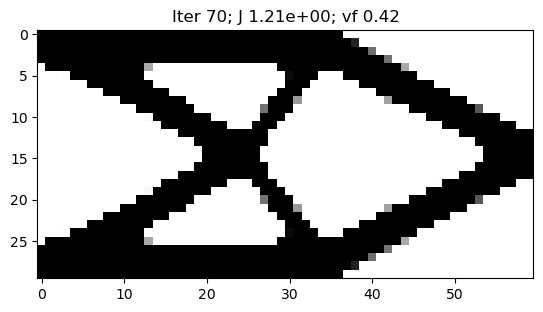

massConstraint tensor(8.8930e-05, grad_fn=<SubBackward0>)
Iter 71; J 1.21e+00; vf 0.42
total time(s):  45.523744164034724
mma time(s):  34.614561586407945
FE time(s):  10.90918257762678


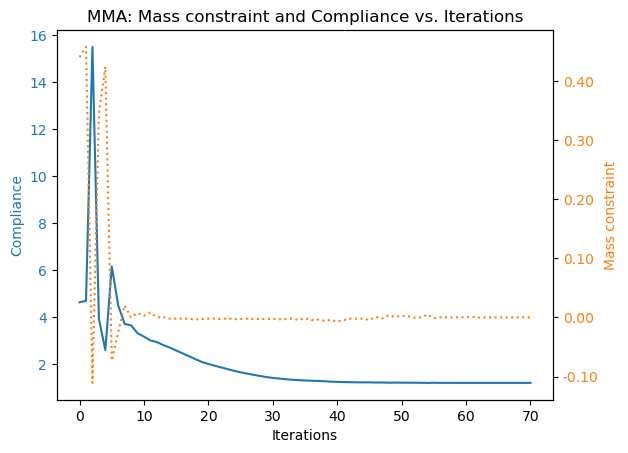

In [8]:
nx, ny = 60, 30# 120, 80 # 60,30
elemSize = np.array([1,1]);
meshProp = {'type':'grid','ndim':2, 'thickness':1, 'nelx':nx, 'nely':ny, 'elemSize':elemSize, 'dofsPerNode':2}

maxvol = nx*ny*meshProp['thickness']*elemSize[0]*elemSize[1] # 60x30 mesh

maxMass = maxvol * 10** dataInfo['MassDensity']['scaleMax'] # 1.5 is the factor to increase the mass
# print('maxMass', maxMass)


bc = getBC(2, meshProp);

mesh = RectangularGridMesher(meshProp, bc['physics']);

matProp = {'physics':'structural', 'nu':0.3}
matProp['penal'] = 3.0 # SIMP penalization constant, starting value
material = Material(matProp, bc['physics'])
constraints = {'volume': {'isOn':False, 'desiredVolumeFraction':0.4},\
                'mass': {'isOn':True, 'maxMass': 5e3},\
                    'distance': {'isOn':False, 'center':torch.tensor(center), 'a':torch.tensor(a), 'b':torch.tensor(b), 'theta':torch.tensor(t), 'delta':0, 'beta':20}}    
        #   Compute the softmax constraint value for a set of points based on the SDF of an ellipse.
        # 5e3 is the max mass for 60x30 mesh
        #   Parameters:
        #   - points: (N, 2) array of 2D points to evaluate.
        #   - center: (x_c, y_c), center of the ellipse.
        #   - a: Semi-major axis length of the ellipse.
        #   - b: Semi-minor axis length of the ellipse.
        #   - theta: Rotation angle of the ellipse in radians.
        #   - delta: Optional delta to shift the SDF boundary (default: 0).
        #   - beta: Sharpness parameter for the softmax constraint (default: 10).
        #   Returns:
        #   - Softmax constraint value (single scalar).


topOpt = TopologyOptimizer(mesh, material, bc, materialEncoder, constraints);

# topOpt.testFEAandGrad()
optimizationParams = {'maxIters':100,'minIters':10,'relTol':0.0001}

result = topOpt.testMMA(optimizationParams)

# zOpt, convergenceHistory = topOpt.optimizeDesign(optParams);





In [9]:
print(result)

[0.99998097 0.99997943 0.99996866 ... 0.23371116 0.23374695 0.23374645]


In [10]:
res = topOpt.map_to_ellipse_torch(torch.tensor(result, requires_grad=True)).detach().numpy()

In [11]:
reCopy = res.copy().reshape((3,-1)).T


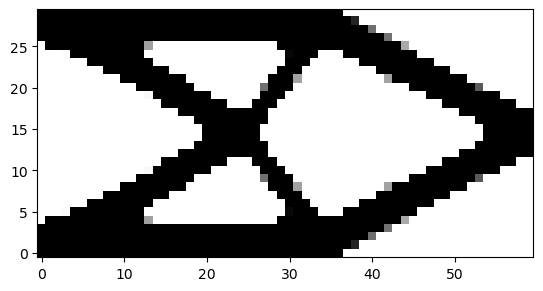

In [12]:
xDesign = reCopy[:,0].reshape((nx,ny)).T

plt.imshow(xDesign, cmap='gray_r',origin='lower')


zD = reCopy[:,[1,2]].copy()

zDomain = zD.copy()
# zDomain = topOpt.unnormalize_last_n(zD,2*topOpt.mesh.meshProp['numElems'])



In [13]:
def getMaterialProperties(decoded):
  def unlognorm(x, scaleMax, scaleMin):
    return 10**(x*(scaleMax-scaleMin) + scaleMin)
  youngModulus = unlognorm(decoded[:,materialEncoder.dataInfo['ElasticModulus']['idx']], 
                            materialEncoder.dataInfo['ElasticModulus']['scaleMax'],
                            materialEncoder.dataInfo['ElasticModulus']['scaleMin'])
  physicalDensity = unlognorm(decoded[:,materialEncoder.dataInfo['MassDensity']['idx']],
                      materialEncoder.dataInfo['MassDensity']['scaleMax'],
                      materialEncoder.dataInfo['MassDensity']['scaleMin'])
  return youngModulus, physicalDensity


decoded = materialEncoder.vaeNet.decoder(torch.tensor(zDomain).float())
youngModulus, massDensity = getMaterialProperties(decoded)
youngModulus = youngModulus.detach().numpy()
massDensity = massDensity.detach().numpy()



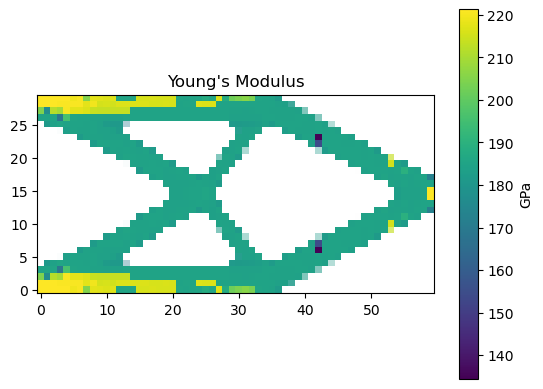

In [14]:
plt.figure()
rho_den = xDesign
# a = np.where(xDesign > 0.9, 1.0, 0.0)
plt.imshow(youngModulus.reshape((nx,ny)).T, cmap='viridis', origin='lower', alpha= rho_den)
plt.title('Young\'s Modulus')
plt.colorbar(label='GPa')

Has an alpha based on xDesign.

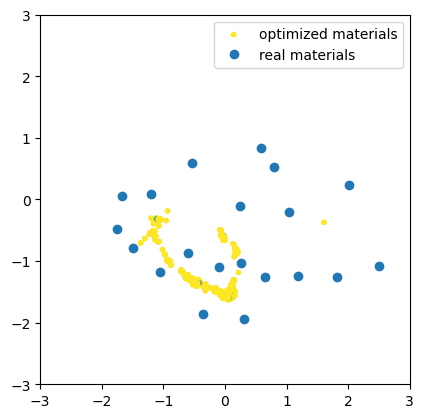

In [15]:
# ellipse = Ellipse(xy=center, width=2*a, height=2*b, angle=np.degrees(t), edgecolor='k', fc='green', alpha=0.3, lw=2)

fig, ax = plt.subplots()
plt.scatter(zDomain[:,0], zDomain[:,1], c=rho_den, s=10, alpha=rho_den, label='optimized materials')
plt.plot(zReal[:,0], zReal[:,1], 'o', label='real materials')
# ax.plot(zReal[:,0], zReal[:,1], 'o')
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])

ax.set_aspect('equal')
plt.legend()

plt.show()

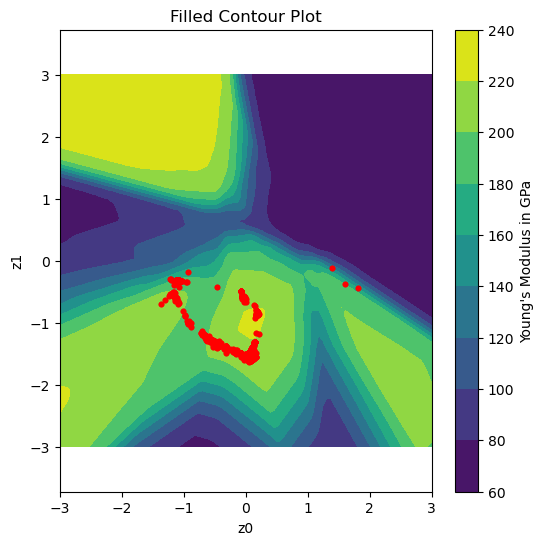

In [16]:
def create_meshgrid(n):
    x = np.linspace(-3, 3, n)
    y = np.linspace(-3, 3, n)
    X, Y = np.meshgrid(x, y)

    return X, Y

def meshgrid_to_tensor(X, Y):
    # Flatten X and Y and stack them along the last axis to create (n*n, 2) shape
    X_flat = X.flatten()
    Y_flat = Y.flatten()
    points_tensor = torch.stack([torch.tensor(X_flat), torch.tensor(Y_flat)], dim=1)
    return points_tensor.float()

def unlognorm(x, scaleMax, scaleMin):
    return 10.**(x*(scaleMax-scaleMin) + scaleMin)
# Define a function to evaluate at the grid points (example: a simple function)
def functional_value(points_tensor):


    decoded = materialEncoder.vaeNet.decoder(points_tensor)
    youngModulus = unlognorm(decoded[:,materialEncoder.dataInfo['ElasticModulus']['idx']], 
                              materialEncoder.dataInfo['ElasticModulus']['scaleMax'],
                              materialEncoder.dataInfo['ElasticModulus']['scaleMin'])
    physicalDensity = unlognorm(decoded[:,materialEncoder.dataInfo['MassDensity']['idx']],
                        materialEncoder.dataInfo['MassDensity']['scaleMax'],
                        materialEncoder.dataInfo['MassDensity']['scaleMin'])
    return youngModulus.detach().numpy().reshape((100,100)), physicalDensity.detach().numpy().reshape((100,100))

def plot_filled_contour(X, Y, Z):
    plt.figure(figsize=(6, 6))
    contour = plt.contourf(X, Y, Z, cmap='viridis')  # Use a colormap
    # plt.colorbar(contour)  # Add colorbar to show the scale
    plt.colorbar(label='Young\'s Modulus in GPa')
    plt.title('Filled Contour Plot')
    # plt.xlabel('X')
    # plt.ylabel('Y')
    plt.axis('equal')
    # plt.show()

# Main
n = 100  # Number of points in each direction
X, Y = create_meshgrid(n)
points_tensor = meshgrid_to_tensor(X, Y)
Z0,Z1 = functional_value(points_tensor)
plot_filled_contour(X, Y, Z0)
plt.scatter(zDomain[:,0], zDomain[:,1], c='r', s=10)
plt.xlabel('z0')
plt.ylabel('z1')
plt.show()

# Z = functional_value(X, Y)
# plot_filled_contour(X, Y, Z)
